<a href="https://colab.research.google.com/github/nji1997/python-random-quote/blob/master/Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bigfoot Data Analysis
Ned Buckley, Nick Irby, and Aidan Desjardins

In [ ]:
pip install geopandas


In [ ]:
pip install -U mapclassify

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import geopandas
from collections import Counter
import mapclassify as mc
from shapely.ops import cascaded_union
import statsmodels.formula.api as smf
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json
from google.colab import files


##Data Cleansing:

Our data cleansing process occurred in a few steps to get the data where it had to be for analysis.  

>- The first step was to clear the bigfoot dataset of any observations that did not have either either a latitude or longitude value(or both).  This was done because with our primary analysis of sightings focusing on location, and variables for each location, it would not make sense to include bigfoot sightings whose locations were unknown.  

>- Our analysis of bigfoot sightings also was focused on the contiguous United States(US).  So our final cleansing of the dataset focused on removing any sightings that occurred outside the contiguous US, such as removing any sightings from Alaska or Hawaii.

>- The next step was to clean the data gathered for the counties.  This, again, primarily focused on removing any county data that was not part of the contiguous US.

After this cleansing process we then combined all of our county data, which had previously been split between location details and county specific variables(income, population, households etc.).  Then we were able to locate the specific amount of bigfoot sightings that occurred in each county, which allowed us to delve further into the data with many different plots.


In [ ]:
big = pd.read_csv("bigfoot.csv")
big = big.dropna(subset =['longitude', 'latitude','date'])
big['year'] =  pd.DatetimeIndex(big['date']).year
county = pd.read_csv("county_data.csv")

In [ ]:
county = county[county.state != "Puerto Rico"]
county = county[county.state != "American Samoa"]
county = county[county.state != "Northern Mariana Islands"]
county = county[county.state != "Alaska"]
county = county[county.state != "Hawaii"]
county = county[county.state != "Guam"]
county = county[county.state != "U.S. Virgin Islands"]
county = county.dropna()
county["NAME"] = county["county"]

In [ ]:
cz = geopandas.read_file("county_geo.zip")

In [ ]:
cz = cz[cz.STATEFP != '02']
cz = cz[cz.STATEFP != '15']
cz = cz[cz.STATEFP != '60']
cz = cz[cz.STATEFP != '66']
cz = cz[cz.STATEFP != '69']
cz = cz[cz.STATEFP != '72']
cz = cz[cz.STATEFP != '78']
cz['COUNTYID'] = cz.STATEFP + cz.COUNTYFP

In [ ]:
biggeo = geopandas.GeoDataFrame(big, geometry = geopandas.points_from_xy(big.longitude, big.latitude), crs = 'EPSG:4326')
biggeo = biggeo[biggeo.latitude < 51]
biggeo = biggeo[biggeo.longitude > -130]
biggeo3 = biggeo.reset_index()

In [ ]:
for sighting in biggeo3.index:
  x = [biggeo3.at[sighting,'geometry'].within(c) for c in cz.geometry]
  biggeo3.at[sighting, 'County_ID'] = cz.COUNTYID[x].values

In [ ]:
biggeo3.to_csv("Bigclean.csv")

In [ ]:
files.download('Bigclean.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
big = pd.read_csv("bigclean2.csv")
big['year'] =  pd.DatetimeIndex(big['date']).year
big = big[big.date != '1869-11-10']
big = big.dropna(subset =['longitude', 'latitude'])
biggeo = geopandas.GeoDataFrame(big, geometry = geopandas.points_from_xy(big.longitude, big.latitude), crs = 'EPSG:4326')
biggeo = biggeo[biggeo.latitude < 51]
biggeo = biggeo[biggeo.longitude > -130]

In [ ]:
czmerge = pd.merge(cz, county, how = 'left', on = "NAME")
czmerge2 = czmerge.dropna()
czmerge2['income_per_cap'] = czmerge2['income_per_cap'].replace('[\$\,\.]',"",regex=True).astype(int)
czmerge2['population'] = czmerge2['population'].replace('[\$\,\.]',"",regex=True).astype(int)

##Bigfoot Sightings Over the US:


The plot below shows bigfoot sightings placed on a map of the US from where the sighting occurred.

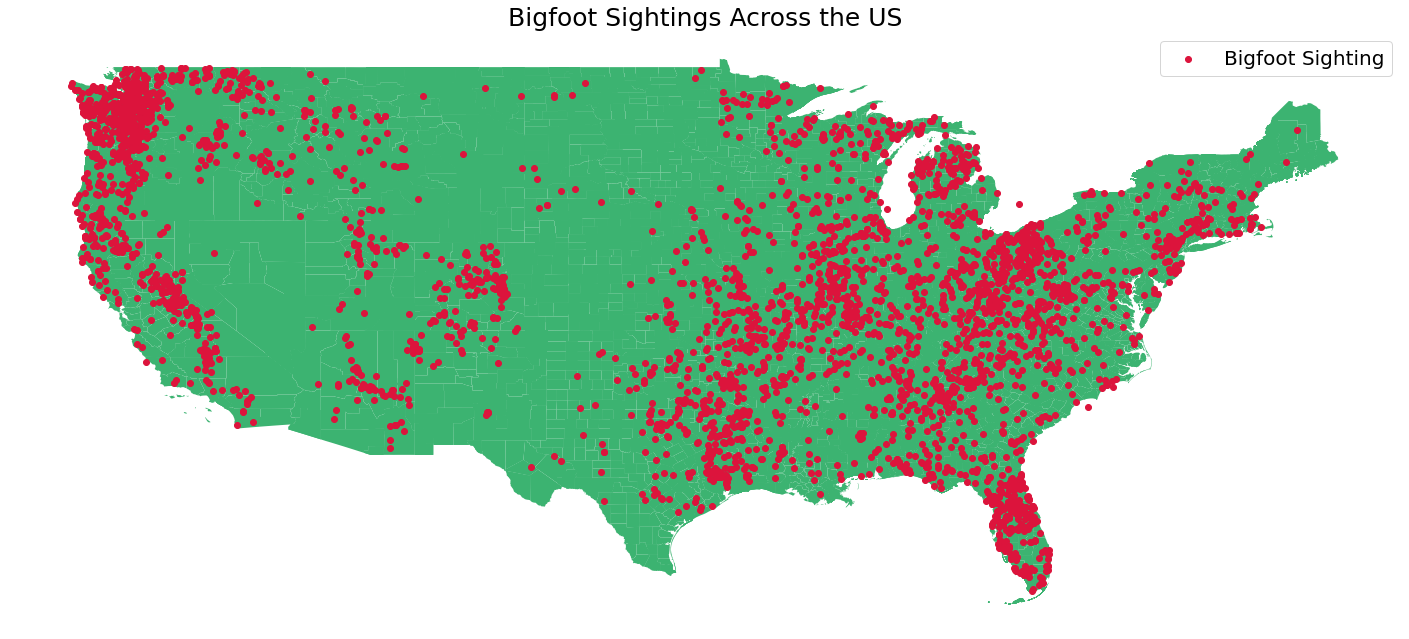

In [ ]:
fig, ax = plt.subplots(figsize = (25,25))

czmerge.plot(ax = ax, color = 'mediumseagreen')
biggeo.plot(ax = ax, color = 'crimson', label = 'Bigfoot Sighting')
ax.set_aspect('equal')
plt.title("Bigfoot Sightings Across the US", fontsize = 25)
ax.legend(fontsize = 20)
ax.set_axis_off()

In [ ]:
biggeo['COUNTYID']=biggeo['County_ID']

From this map we can see a heavy concentration of sightings in many different locations.  At first glance it would seem that the most sightings happen in the Northwest, Florida, and throughout the eastern half of the US.  Conversely, the Midwestern portion of the US seems to have relatively fewer sightings than the rest of the country.

In [ ]:
b4 = biggeo.groupby('COUNTYID').size()
b4 = pd.DataFrame(b4)

In [ ]:
b5 = b4.reset_index()

In [ ]:
b5 = b5.rename(columns = {'COUNTYID':'COUNTYID', 0: 'NUM'})

In [ ]:
czmerge3 = pd.merge(cz, b5, how = 'left', on = 'COUNTYID')

In [ ]:
czmerge3['NUM'] = czmerge3['NUM'].fillna(0)

##US Counties Colored by Amount of Sightings:




It was easy to see the concentration of sightings across the US, but we are interested in the amount of sightings in each county, and the possibility of some related variables.  

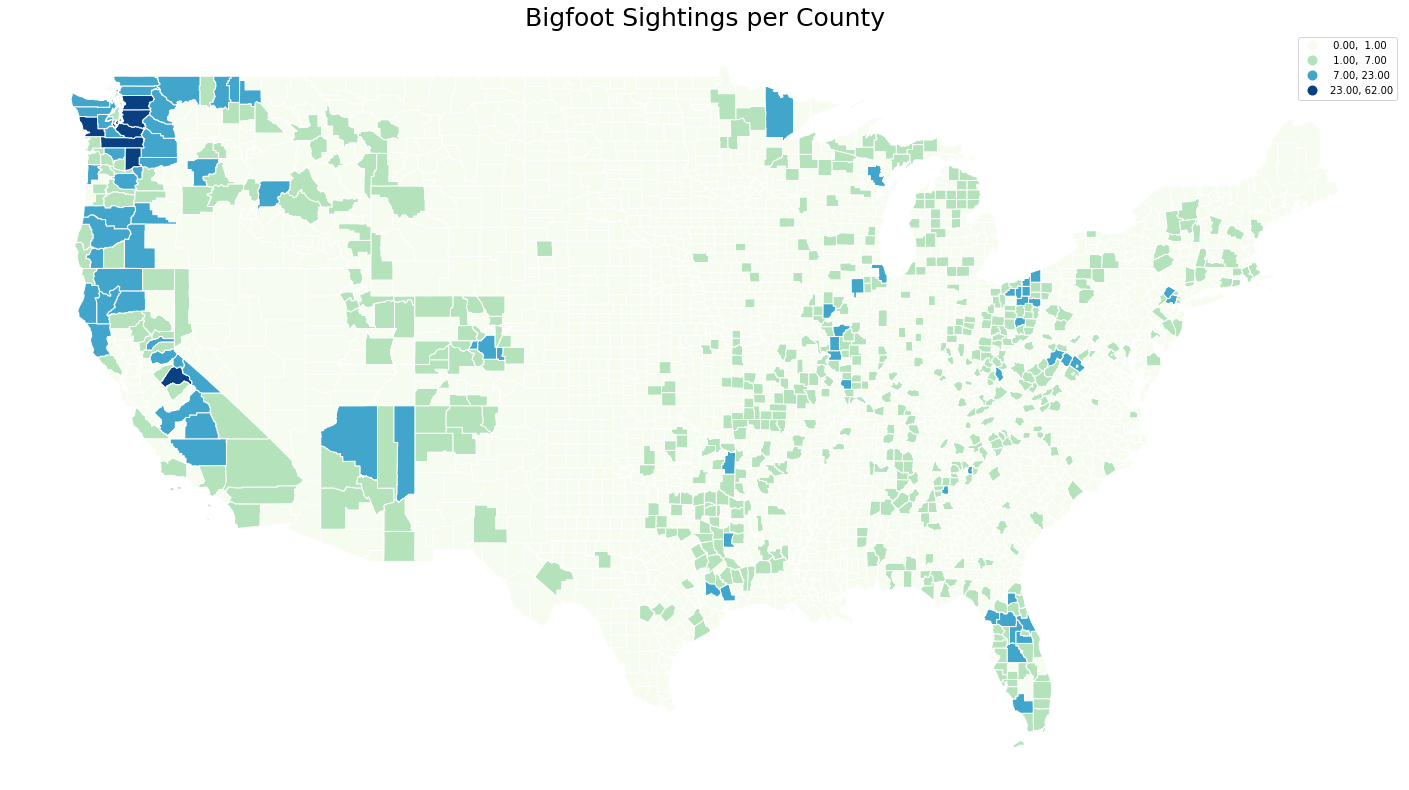

In [ ]:
fig, ax = plt.subplots(figsize = (25,25))

czmerge3.plot(ax = ax, figsize = (25,25), column = 'NUM', cmap = "GnBu", edgecolor = 'white', scheme = 'NaturalBreaks',k=4, legend = True)
plt.title("Bigfoot Sightings per County", fontsize = 25)
ax.set_axis_off()

From the map above, the counties colored by amount of bigfoot sightings gives the same conclusion as the map of sightings across the US.  We see many counties with a high amount of sightings(colored navy blue) in the Northwestern US.  Florida, California have a large amount of sightings in the range of 7-23, and the eastern half of the US has a scattering of counties within the same range.  What the map shows us, surprisingly, is that while the sightings in the Midwestern US seemed sparce, it would appear that when there were sightings, that they often occurred in the same county.  This is seen by the large amount of counties with zero sightings, but also the high amount of counties grouped into the 1-7 and 7-23 sighting ranges.

Now that we have a clear idea of the amount of sightings that occurred in each county, we are now able to delve further into county specific variables, and see whether there are any patterns between the amount of sightings in the county and the population of the county, and the amount of sightings in the county and the counties income per capita.

##Number of Bigfoot Sightings vs. County Specific Variables:

The next step in the analysis of our data was to look deeper into variables at the county level to see if there is any association between those variables and the number of bigfoot sightings.

The first county specific variable we wanted to look at was county income per capita.  We were interested in seeing whether counties holding wealthier people would have more or less bigfoot sightings.  A scatterplot of the number of bigfoot sightings vs. the county's income per capita describing this relationship is shown below.

In [ ]:
czmerge4 = pd.merge(czmerge2, b5, how = 'left', on = 'COUNTYID')

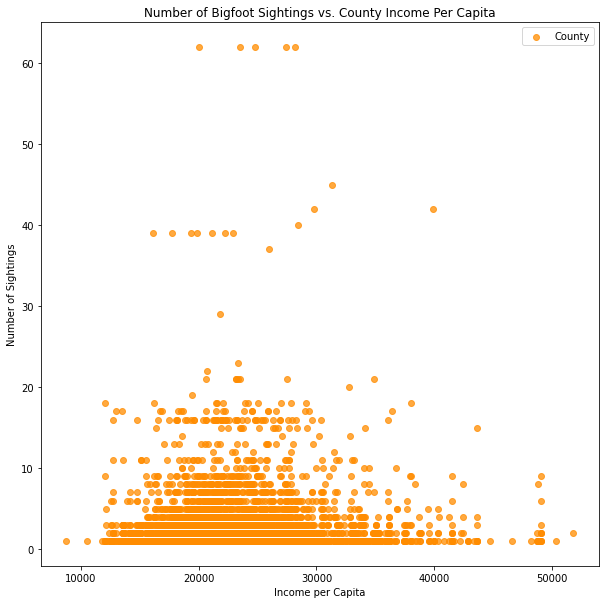

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

plt.scatter(czmerge4.income_per_cap,czmerge4.NUM, label = 'County', alpha = .75, c = 'darkorange')
plt.xlabel("Income per Capita (in $'s)")
plt.ylabel("Number of Sightings")
plt.title("Number of Bigfoot Sightings vs. County Income Per Capita")
plt.legend()

Looking at the plot above, we can see a sort of curvilinear relationship between the number of sightings and county income per capita.  From counties between the 20,000 and 30,000 dollar income per capita range, we see the largest grouping of counties with high sightings, and also includes the counties with the highest number of bigfoot sightings.  As income continues to increase, however, there are a continually fewer amount of counties with many bigfoot sightings.

The next relationship we were interested in exploring was the relationship between the number of bigfoot sightings in a county, and the county's population.  Again, there is a scatterplot showing the relationship between the two below.

Text(0.5, 1.0, 'Number of Bigfoot Sightings vs. County Population')

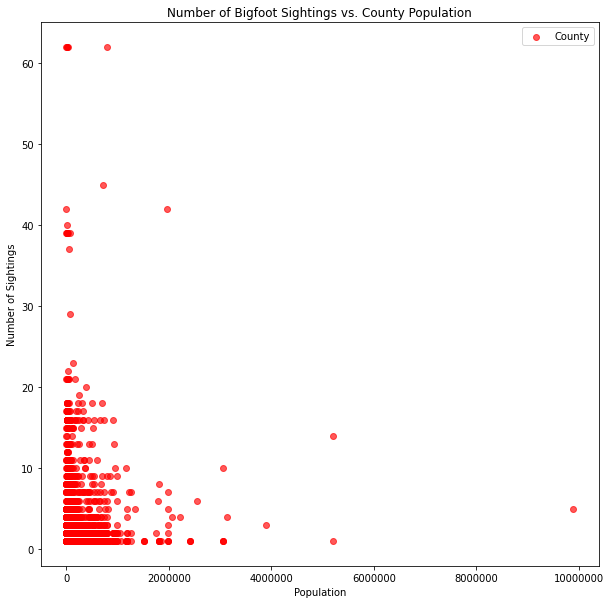

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

plt.scatter(czmerge4.population,czmerge4.NUM, c = 'red', alpha = .65, label = 'County')
plt.ticklabel_format(axis = "x", style = "plain")
plt.legend()
plt.xlabel("Population")
plt.ylabel("Number of Sightings")
plt.title("Number of Bigfoot Sightings vs. County Population")

Again, by looking at the plot above, we see a semi-curvilinear relationship.  We see that when county population is low, there are many points of bigfoot sightings in the county being very high  As with county income per capita, there appears to be less bigfoot sightings in the county as its population increases.

##Bigfoot Sightings Over Time:

Text(0.5, 1.0, 'Bigfoot Sightings Per Year')

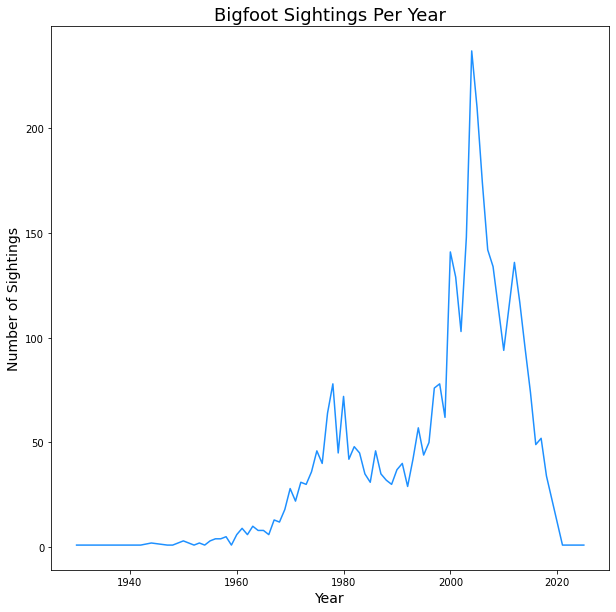

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

biggeo2 = biggeo.groupby('year').size()
biggeo2.plot(ax = ax, color = 'dodgerblue')
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Number of Sightings", fontsize = 14)
plt.title("Bigfoot Sightings Per Year", fontsize = 18)

##Common Narrative Descriptions of the Bigfoot Sighting:

The final aspect of the bigfoot data we were interested in looking into was to see what some common words, and descriptors were used in the explanation attached to each sighting.  To do this we created a Wordcloud of common words that appeared in the desriptions, but not including certain words(listed below under "Wordcloud Methodology").

Wordcloud Methodology: 
 
We converted the 'observations' column from the bigfoot.csv file to a string in order to parse and find the most used words for our word cloud. 

We excluded the following words from consideration: 

{'by', 'yours', 'of', "here's", 'against', 'doing', 'else', 'get', "they'll", 'we', "don't", 'why', 'also', 'some', "she'd", "when's", 'down', "mustn't", 'from', 'as', 'once', 'do', 'here', 'out', 'be', 'or', "where's", "there's", 'under', "who's", 'above', "he'll", "why's", 'these', 'has', 'more', 'few', 'would', 'just', "that's", 'no', 'there', 'k', "let's", 'but', "how's", 'their', "you're", 'when', "wouldn't", 'those', 'too', 'however', 'through', 'had', "we'd", 'him', 'below', 'ever', 'having', 'his', "she'll", "she's", 'such', 'was', 'any', 'at', 'them', 'can', 'ours', 'does', 'i', "it's", "wasn't", 'to', 'both', "you've", 'ought', "we're", 'nor', 'her', 'into', "you'd", "hasn't", 'same', "isn't", 'until', "hadn't", 'he', 'other', "they'd", 'very', 'been', '

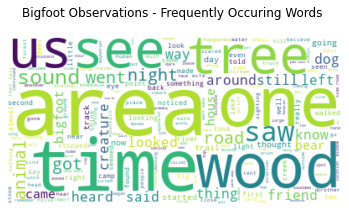

<Figure size 1440x1296 with 0 Axes>

In [ ]:

df = pd.read_csv("bigfoot.csv")
text = df['observed'].to_json()
wordcloud = WordCloud(stopwords = STOPWORDS, background_color="white").generate(text)
fig = plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("Bigfoot Observations - Frequently Occuring Words \n")
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
fig = plt.figure(figsize=(20, 18))
print("Wordcloud Methodology: \n \nWe converted the 'observations' column from the bigfoot.csv file to a string in order to parse and find the most used words for our word cloud. \n\nWe excluded the following words from consideration: \n\n%s" %STOPWORDS)


From the wordcloud, there are many common words that appear such as heard, night, sound, see, tree, creature, bear, trail, thing, road, wood, and track.  This could mean many people thought they were at first seeing a bear when they saw bigfoot, or that it was a foreign object to them, which is why they included "thing".  Seeing that "wood" and "night" came up a lot in the descriptions could describe to us that many bigfoot sightings take place at night and/or in the woods, and this idea could be enforced by the amount of times "trail" is included in the description.  Overall, by looking at the common words included, more light can be shedded on the circumstances common within most sightings, that regular data analysis would not turn up.